## Install packages

In [ ]:
!pip install boruta

In [ ]:
!pip install sklearn-genetic

In [ ]:
!pip install feature-selection-ga

## Synthetic Data

In [ ]:
import numpy as np
from numpy import logical_or as lor
from numpy import logical_and as land
from numpy import logical_not as lnot
from numpy import logical_xor as lxor
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# generate a list of all possible combinations of 3-bits
def gen_3():
  rlvnt = []
  for i in [0,1]:
    for j in [0,1]:
      for k in [0,1]:
        rlvnt.append([i,j,k])
  return rlvnt

# create 2 correlated features in case of binary target (y)
# by randomly fliping 30% of the values of y

def make_cor(y):
  random.seed(0)
  cor_vars = []
  for i in range(2):
    cor_i = y.copy()
    ind = random.sample(range(len(y)), int(0.3*len(y)))
    cor_i[ind] = lnot(cor_i[ind])
    cor_vars.append(cor_i)
  return np.array(cor_vars).transpose()

### ORAND

In [ ]:
def orand(n_obs=50,n_I=92, seed=0):
  np.random.seed(seed)
  red = lnot(gen_3()).astype(int) #redundant variables
  rr = np.hstack([gen_3(), red]) #rlvnt & rdnt joined
  q=n_obs//8
  r=n_obs%8
  rr_exp = np.vstack([np.repeat(rr,q, axis=0),rr[:r,:]]) #replicate rr according to n_obs
  irlvnt = np.random.randint(2, size=[n_obs,n_I], )
  y = land(rr_exp[:,0],
           lor(rr_exp[:,1], rr_exp[:,2])).astype(int) #calculate y according to the formula
  cor = make_cor(y)
  features = np.hstack([rr_exp,cor, irlvnt])
  return features, y

X, y = orand(seed=1)

### ANDOR

In [ ]:
# generate a list of all possible combinations of 3-bits
def gen_4():
  rlvnt_0 = gen_3()
  for seq in rlvnt_0:
    seq.append(0)

  rlvnt_1 = gen_3()
  for seq in rlvnt_1:
    seq.append(1)

  return rlvnt_0 + rlvnt_1


def andor(n_obs=50,n_I=90, seed=0):
  np.random.seed(seed)
  red = lnot(gen_4()).astype(int)
  rr = np.hstack([gen_4(), red])
  q=n_obs//16
  r=n_obs%16
  rr_exp = np.vstack([np.repeat(rr,q, axis=0),rr[:r,:]])
  irlvnt = np.random.randint(2, size=[n_obs,n_I])
  y = lor(land(rr_exp[:,0], rr_exp[:,1]),
          land(rr_exp[:,2], rr_exp[:,3])).astype(int)
  cor = make_cor(y)
  features = np.hstack([rr_exp, cor, irlvnt])
  return features, y

X, y = andor()

### ADDER

In [ ]:
# make 2 correlated features when n_class => 2
# this is more general than make_cor which works only when n_class=2
# works by adding 1 to the y value and modding
# flips 30% of y values

def make_cor_adv(y, n_class=4):
  n_ind = int(0.3*len(y))
  cor_vars = []
  for i in range(2):
    random.seed(0)
    np.random.seed(0)
    cor_i = y.copy()
    ind = random.sample(range(len(y)), n_ind)
    adjust = np.random.randint(n_class, size=n_ind)
    cor_i[ind] = (cor_i[ind]+adjust)%n_class
    cor_vars.append(cor_i)
  return np.array(cor_vars).transpose()

In [ ]:
def adder(n_obs=50,n_I=92, seed=0):
  np.random.seed(seed)
  red = lnot(gen_3()).astype(int)
  rr = np.hstack([gen_3(), red])
  q=n_obs//8
  r=n_obs%8
  rr_exp = np.vstack([np.repeat(rr,q, axis=0),rr[:r,:]])
  irlvnt = np.random.randint(2, size=[n_obs,n_I])
  y1 = lxor(lxor(rr_exp[:,0], rr_exp[:,1]),
            rr_exp[:,2]).astype(int)
  y2 = lor(land(rr_exp[:,0], rr_exp[:,1]),
           land(rr_exp[:,2], lxor(rr_exp[:,0], rr_exp[:,1]))).astype(int)
  y = [y1[j] + 2*y2[j] for j in range(len(y1))]
  cor = make_cor_adv(np.array(y))
  features = np.hstack([rr_exp, cor, irlvnt])
  return features, y

X, y = adder(n_obs=50,n_I=92, seed=0)

### LED

In [ ]:
# import the table showing which LED segments light up for each character
url = "https://raw.githubusercontent.com/SaidElnaffar/Synthetic-Datasets-for-Features-Selection-Algorithms/0ae683f12ae664291d195aff364dbeaa2b4014d9/16_segment_truth_table2.csv"
df = pd.read_csv(url, on_bad_lines='skip')

#df = pd.read_csv('16_segment_truth_table2.csv')

df = df.fillna(0)
df.index = df.iloc[:,0].values
df.drop(columns='char', inplace=True)
df = df.astype(int)

def led(df, n_obs=180,n_I=66, seed=0):
    np.random.seed(seed)
    rlvnt = df.values
    red = np.logical_not(rlvnt)
    rr = np.hstack([rlvnt, red])
    d = rlvnt.shape[0]
    q=n_obs//d
    r=n_obs%d
    rr_exp = np.vstack([np.repeat(rr, q, axis=0), rr[:r,:]])
    irlvnt = np.random.randint(2, size=[n_obs,n_I])
    y = np.array(range(36))
    y = np.hstack([np.repeat(y, q), y[:r]])
    cor = make_cor_adv(y, n_class=36)
    features = np.hstack([rr_exp, cor, irlvnt])
    return features, y


X, y = led(n_obs=180,n_I=90, df=df)

# Feature selection

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, SVR
import numpy as np
import random
from sklearn.model_selection import train_test_split

### Selector

In [ ]:
#Helper function for the proposed method
def selector(X,y):
    oob_scores=list()
    for c in range(X.shape[1]):
        X_c = np.delete(X,c,1)
        clf = RandomForestClassifier(oob_score=True, random_state=0)
        clf.fit(X_c,y)
        oob_scores.append(clf.oob_score_)

    max_c = np.argmax(oob_scores)
    sprt = X.shape[1]*[True]
    sprt[max_c]=False

    return oob_scores[max_c], sprt

## ANDOR experiment

### NES

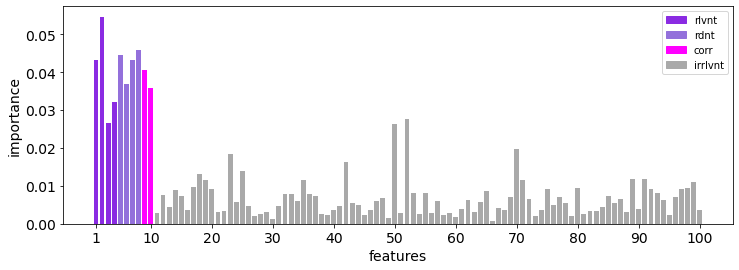

In [ ]:
# Evaluate features for ordinal-values data
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier



rfc = RandomForestClassifier(max_depth=2, random_state=0)
etc = ExtraTreesClassifier(n_estimators=100, random_state=0)


seed=0
n_obs=50
X, y = andor(n_obs=n_obs,seed=seed)

rfc.fit(X, y)
etc.fit(X, y)

plt.figure(figsize=(12,4))
feature_score = (etc.feature_importances_+rfc.feature_importances_)/2
colors=4*['blueviolet']+4*['mediumpurple']+2*['magenta']+90*['darkgray']
plt.bar(range(1, X.shape[1]+1),feature_score, color=colors, label='RFC')


plt.legend()
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=14)
plt.ylabel('importance', size=14)
colors = {'rlvnt':'blueviolet', 'rdnt':'mediumpurple', 'corr':'magenta', 'irrlvnt':'darkgray'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig('imagesNew/andor_scores.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# make data
seed=0
n_obs=50
X, y = andor(n_obs=n_obs,seed=seed)

# Select top 20 based on combined scores
threshold = np.sort(rfc.feature_importances_ + etc.feature_importances_)[X.shape[1]-21]
idx = (rfc.feature_importances_ + etc.feature_importances_)>threshold
X = X[:,idx] # update X


# make containers for the results
scores_=list()
features_=list()
col_names = np.arange(1,101)[idx]
features_.append(col_names)
start= X.shape[1]
end=2

for j in range(start, end, -1):
    if j%4==0: print(j)
    accuracy, sprt = selector(X, y)
    scores_.append(accuracy)
    col_names = col_names[sprt]
    features_.append(col_names)
    X = X[:,sprt]

20
16
12
8
4


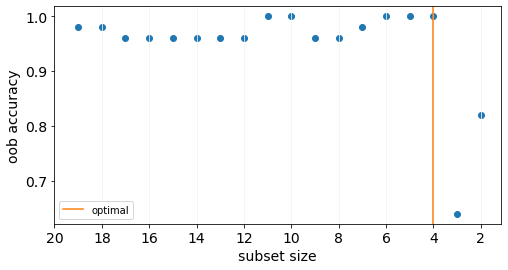

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(range(start-1, end-1, -1), scores_)
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
#plt.title('ANDOR')
plt.gca().invert_xaxis()
plt.ylabel('oob accuracy', size=14)
plt.xlabel('subset size', size=14)
plt.axvline(4, color='C1', label='optimal')
plt.grid(axis='x', color='0.95')
plt.legend()
plt.savefig('imagesNew/andor_oob.pdf', bbox_inches='tight')
plt.show()

### MRMR

In [ ]:
# create some pandas data
X, y = andor(n_obs=50,seed=0)

X = pd.DataFrame(X)
y = pd.Series(y)

# select top 10 features using mRMR
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X, y=y, K=10, return_scores=True)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 42.92it/s]


In [ ]:
np.array(selected_features[1].sort_values(ascending=False).iloc[:10].index)+1

array([ 9,  1,  4,  2,  5,  6,  8, 10, 52,  3])

###Boruta

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
np.random.seed(123)
random.seed(123)

rankings = []
for i in range(5):
    print(i)
    X, y = andor(n_obs=50, seed=i)
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)
    feat_selector.fit(X, y)
    rankings.append(feat_selector.ranking_[:100])

np.median(rankings, axis=0).astype('int')

0
1
2
3
4


array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 60, 54, 29, 35, 37, 78, 45,
       29, 65, 38, 60, 78, 38, 41, 54, 52, 52, 73, 79, 63, 39, 63, 49, 49,
       46, 35, 24, 74, 42, 41, 29, 42, 68, 38, 79, 34, 40, 55, 29, 34, 12,
       32, 24, 67, 35, 56, 65, 53, 43, 49, 46, 28, 52, 40, 70, 74, 56, 34,
       38, 23, 65, 45, 53, 48, 31, 15, 30, 36, 23, 34, 48, 55, 31, 50, 35,
       26, 47, 25, 33, 73, 28, 72, 53, 66, 38, 19, 29, 41, 20, 51])

In [ ]:
med_rank = np.median(rankings, axis=0).astype('int')
np.where(med_rank==1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)

### Genetic FS CV

In [ ]:
import random
import numpy as np
from sklearn import linear_model
from sklearn.svm import LinearSVC
from genetic_selection import GeneticSelectionCV

np.random.seed(123)
random.seed(123)


X, y = andor(n_obs=50)
y=np.array(y)

estimator = LinearSVC()

selector = GeneticSelectionCV(
    estimator,
    cv=5,
    verbose=0,
    scoring="accuracy",
    max_features=10,
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=100,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.05,
    tournament_size=3,
    n_gen_no_change=10,
    caching=True,
    n_jobs=-1,
)
selector = selector.fit(X, y)
selector.support_.astype('int')

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
np.where(selector.support_.astype('int')==1)[0] + 1

array([ 3,  4, 50])

### RFE

In [ ]:
np.random.seed(123)
random.seed(123)

X, y = andor(n_obs=50)
y=np.array(y)
estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X, y)
selector.ranking_

array([  9,   8,  20,  10,   5,   4,   2,   3,   7,  15,  50,  40,  62,
        96,  60,  99,  38,  52,  66,  13,  29,  59,  24,  49,  93,  27,
        25,  98,  75, 100,  97,  92,  39,  32,  73,  18,  84,  54,  48,
        77,  78,  26,  68,  88,  37,  57,  80,  56,  85,   1,  64,  14,
        46,  17,  58,  16,  72,  86,  65,  63,  83,  71,  55,  23,  70,
        89,  47,  44,  41,  22,  36,  12,  76,  34,  21,  81,  87,  82,
        91,  94,  30,  79,  74,  51,  11,  53,  61,  67,  69,  42,   6,
        43,  19,  45,  90,  28,  33,  35,  31,  95])


### Lasso

In [ ]:
from sklearn.svm import LinearSVC
X, y = andor(n_obs=50)
np.random.seed(123)
random.seed(123)

#Lasso with C=0.1
rank_list=list()
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X, y)
print([i for i in range(100) if lsvc.coef_[0][i]!=0])

[0, 1, 2, 4, 5, 6, 7, 8, 9, 41, 49, 51]


In [ ]:
np.array([0, 1, 2, 4, 5, 6, 7, 8, 9, 41, 49, 51])+1

array([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 42, 50, 52])

### ElasticNet

In [ ]:
from sklearn.linear_model import LogisticRegression
X, y = andor(n_obs=50)
np.random.seed(123)
random.seed(123)

lr = LogisticRegression(penalty = 'elasticnet',
                        solver = 'saga',
                        l1_ratio = 0.5,
                        C=0.2,
                        max_iter=1000)
lr.fit(X,y)
print([i for i in range(100) if lr.coef_[0][i]!=0])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 41, 49, 51]


In [ ]:
np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 41, 49, 51])+1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 42, 50, 52])

## ORAND

### NES

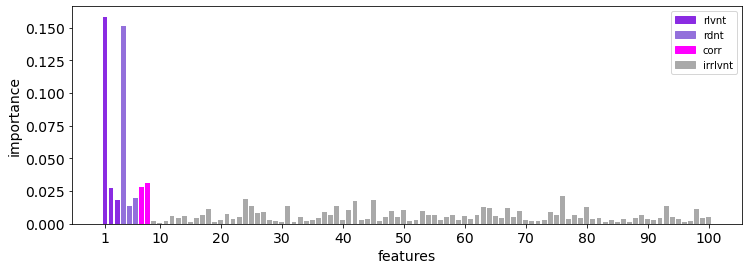

In [ ]:
# Evaluate features for ordinal-values data
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=0)
etc = ExtraTreesClassifier(n_estimators=100, random_state=0)

seed=0
n_obs=50
X, y = orand(n_obs=n_obs,seed=seed)

rfc.fit(X, y)
etc.fit(X, y)


plt.figure(figsize=(12,4))
feature_score = (etc.feature_importances_+rfc.feature_importances_)/2
colors=3*['blueviolet']+3*['mediumpurple']+2*['magenta']+92*['darkgray']
plt.bar(range(1, X.shape[1]+1),feature_score, color=colors, label='RFC')

plt.legend()
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=14)
plt.ylabel('importance', size=14)
colors = {'rlvnt':'blueviolet', 'rdnt':'mediumpurple', 'corr':'magenta', 'irrlvnt':'darkgray'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig('imagesNew/orand_scores.pdf', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

# make data
X, y = orand(n_obs=50,seed=0)

# Select top 20 based on combined scores
threshold = np.sort(rfc.feature_importances_ + etc.feature_importances_)[X.shape[1]-21]
idx = (rfc.feature_importances_ + etc.feature_importances_)>threshold
X = X[:,idx] # update X


# make containers for the results
scores_=list()
features_=list()
col_names = np.arange(1,101)[idx]
features_.append(col_names)
start= X.shape[1]
end=2

for j in range(start, end, -1):
    if j%4==0: print(j)
    accuracy, sprt = selector(X, y)
    scores_.append(accuracy)
    col_names = col_names[sprt]
    features_.append(col_names)
    X = X[:,sprt]

20
16
12
8
4


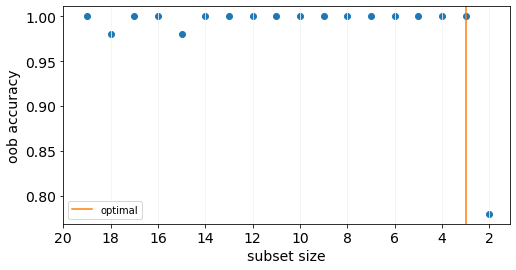

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(range(start-1, end-1, -1), scores_)
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

plt.gca().invert_xaxis()
plt.ylabel('oob accuracy', size=14)
plt.xlabel('subset size', size=14)
plt.axvline(3, color='C1', label='optimal')
plt.grid(axis='x', color='0.95')
plt.legend()
plt.savefig('imagesNew/orand_oob.pdf', bbox_inches='tight')
plt.show()

### MRMR

In [ ]:
# create some pandas data
X, y = orand(n_obs=50,seed=0)

X = pd.DataFrame(X)
y = pd.Series(y)

# select top 10 features using mRMR
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X, y=y, K=10, return_scores=True)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 44.83it/s]


In [ ]:
np.array(selected_features[1].sort_values(ascending=False).iloc[:10].index)+1

array([ 1,  4,  7,  8, 42,  5,  2, 45, 31, 76])

###Boruta

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
np.random.seed(123)
random.seed(123)

rankings = []
for i in range(5):
    print(i)
    X, y = orand(n_obs=50, seed=i)
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)
    feat_selector.fit(X, y)
    rankings.append(feat_selector.ranking_[:100])

np.median(rankings, axis=0).astype('int')

0
1
2
3
4


array([ 1,  4,  6,  1,  2,  7,  1,  1, 78, 37, 55, 46, 17, 67, 55, 32, 30,
       39, 36, 53, 61, 56, 52, 35, 12, 46, 42, 69, 45, 75, 22, 60, 34, 42,
       59, 24, 50, 21, 37, 36, 38,  2, 45, 40, 46, 77, 37, 53, 42, 21, 69,
       52, 43, 56, 64, 51, 48, 81, 65, 56, 29, 72, 86, 30, 45, 79, 24, 49,
       26, 69, 78, 41, 56, 22, 54, 43, 40, 23, 37, 36, 63, 40, 80, 56, 30,
       59, 48, 44, 22, 74, 57, 59, 48, 75, 69, 42, 32, 42, 44, 34])

In [ ]:
med_rank = np.median(rankings, axis=0).astype('int')
np.where(med_rank==1)

(array([0, 3, 6, 7]),)

### Genetic FS CV

In [ ]:
import random
import numpy as np
from sklearn import linear_model
from sklearn.svm import LinearSVC
from genetic_selection import GeneticSelectionCV

np.random.seed(123)
random.seed(123)


X, y = orand(n_obs=50)
y=np.array(y)

estimator = LinearSVC()

selector = GeneticSelectionCV(
    estimator,
    cv=5,
    verbose=0,
    scoring="accuracy",
    max_features=10,
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=100,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.05,
    tournament_size=3,
    n_gen_no_change=10,
    caching=True,
    n_jobs=-1,
)
selector = selector.fit(X, y)
selector.support_.astype('int')

In [ ]:
np.array([ 3, 12, 23, 86]) + 1

array([ 4, 13, 24, 87])

### RFE

In [ ]:
np.random.seed(123)
random.seed(123)

X, y = orand(n_obs=50, seed=0)
estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X, y)
selector.ranking_

array([  2,  15,  11,   1,  35,   4,   9,  29,  95,  54,  84,  61,   5,
        83,  36,  46,  39,  24,  58,  63,  25, 100,  67,   3,  28,  77,
        94,  38,  85,  78,  40,  53,  60,  64,  98,  16,  89,  80,  43,
        51,  14,   7,  59,  41,  18,  76,  97,   8,  70,  22,  66,  96,
        88,  79,  65,  87,  33,  81,  50,  62,  37,  31,  69,  20,   6,
        12,  13,  26,  75,  49,  90,  86,  82,  17,  52,  45,  23,  55,
        72,  93,  34,  68,  42,  71,  56,  74,  10,  44,  21,  57,  48,
        99,  30,  19,  73,  32,  27,  47,  91,  92])


### Lasso

In [ ]:
from sklearn.svm import LinearSVC
X, y = orand(n_obs=50, seed=0)
np.random.seed(123)
random.seed(123)

#Lasso with C=0.1
rank_list=list()
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X, y)
print([i for i in range(100) if lsvc.coef_[0][i]!=0])

[0, 1, 2, 3, 4, 5, 7, 23]


### ElesticNet

In [ ]:
from sklearn.linear_model import LogisticRegression
X, y = orand(n_obs=50,seed=0)
np.random.seed(123)
random.seed(123)

lr = LogisticRegression(penalty = 'elasticnet',
                        solver = 'saga',
                        l1_ratio = 0.5,
                        C=0.2,
                        max_iter=1000)
lr.fit(X,y)
print([i for i in range(100) if lr.coef_[0][i]!=0])

[0, 1, 2, 3, 4, 5, 6, 7, 23, 41]


In [ ]:
import numpy as np
np.array([0, 1, 2, 3, 4, 5, 6, 7, 23, 41]) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8, 24, 42])

## ADDER

### NES

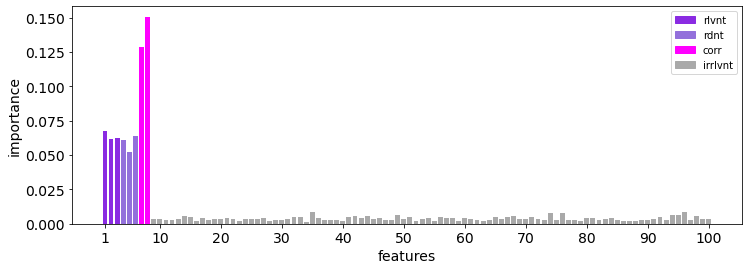

In [ ]:
# Evaluate features for ordinal-values data
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


rfc = RandomForestClassifier(max_depth=2, random_state=0)
etc = ExtraTreesClassifier(n_estimators=100, random_state=0)


seed=0
n_obs=200
X, y = adder(n_obs=n_obs,seed=seed)

rfc.fit(X, y)
etc.fit(X, y)

plt.figure(figsize=(12,4))
feature_score = (etc.feature_importances_+rfc.feature_importances_)/2
colors=3*['blueviolet']+3*['mediumpurple']+2*['magenta']+92*['darkgray']
plt.bar(range(1, X.shape[1]+1),feature_score, color=colors, label='RFC')

plt.legend()
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=14)
plt.ylabel('importance', size=14)
colors = {'rlvnt':'blueviolet', 'rdnt':'mediumpurple', 'corr':'magenta', 'irrlvnt':'darkgray'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig('imagesNew/adder_scores.pdf', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

# make data
seed=0
n_obs=50
X, y = adder(n_obs=n_obs,seed=seed)

# Select top 20 based on combined scores
threshold = np.sort(rfc.feature_importances_ + etc.feature_importances_)[X.shape[1]-21]
idx = (rfc.feature_importances_ + etc.feature_importances_)>threshold
X = X[:,idx] # update X


# make containers for the results
scores_=list()
features_=list()
col_names = np.arange(1,101)[idx]
features_.append(col_names)
start= X.shape[1]
end=2

for j in range(start, end, -1):
    if j%4==0: print(j)
    accuracy, sprt = selector(X, y)
    scores_.append(accuracy)
    col_names = col_names[sprt]
    features_.append(col_names)
    X = X[:,sprt]

20
16
12
8
4


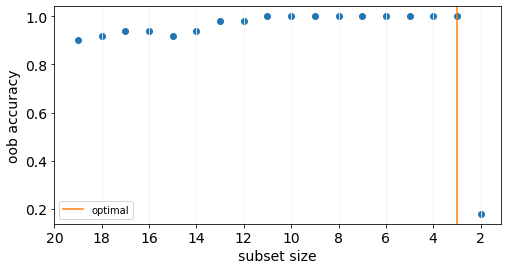

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(range(start-1, end-1, -1), scores_)
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

plt.gca().invert_xaxis()
plt.ylabel('oob accuracy', size=14)
plt.xlabel('subset size', size=14)
plt.axvline(3, color='C1', label='optimal')
plt.grid(axis='x', color='0.95')
plt.legend(loc='lower left')
plt.savefig('imagesNew/adder_oob.pdf', bbox_inches='tight')
plt.show()

### MRMR

In [ ]:
# create some pandas data
X, y = adder(n_obs=50,seed=0)

X = pd.DataFrame(X)
y = pd.Series(y)

# select top 10 features using mRMR
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X, y=y, K=10, return_scores=True)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 44.56it/s]


In [ ]:
selected_features[0]

[6, 93, 76, 7, 30, 66, 0, 2, 1, 3]

###Boruta

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
np.random.seed(123)
random.seed(123)

rankings = []
for i in range(5):
    print(i)
    X, y = adder(n_obs=50, seed=i)
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)
    feat_selector.fit(X, y)
    rankings.append(feat_selector.ranking_[:100])

np.median(rankings, axis=0).astype('int')

0
1
2
3
4


array([ 1,  1,  1,  1,  1,  1,  1,  1, 61, 63, 40, 40, 41, 62, 27, 32, 44,
       49, 33, 53, 56, 59, 35, 22, 20, 51, 80, 61, 34, 48, 32, 46, 32, 29,
       33, 58, 42, 59, 67, 75, 40, 50, 29, 24, 29, 54, 50, 83, 50, 19, 46,
       21, 66, 31, 25, 37, 52, 87, 72, 66, 59, 72, 60, 40, 55, 49, 10, 45,
       58, 34, 80, 75, 30, 44, 21, 42, 35, 25, 21, 14, 42, 53, 28, 54, 45,
       28, 52, 29, 25, 85, 77, 75, 24, 56, 65, 68, 79, 43, 66, 68])

In [ ]:
med_rank = np.median(rankings, axis=0).astype('int')
np.where(med_rank==1)

(array([0, 1, 2, 3, 4, 5, 6, 7]),)

### Genetic FS CV

In [ ]:
import random
import numpy as np
from sklearn import linear_model
from sklearn.svm import LinearSVC
from genetic_selection import GeneticSelectionCV

np.random.seed(123)
random.seed(123)


X, y = adder(n_obs=50)
y=np.array(y)

estimator = LinearSVC()

selector = GeneticSelectionCV(
    estimator,
    cv=5,
    verbose=0,
    scoring="accuracy",
    max_features=10,
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=100,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.05,
    tournament_size=3,
    n_gen_no_change=10,
    caching=True,
    n_jobs=-1,
)
selector = selector.fit(X, y)
selector.support_.astype('int')

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
np.where(selector.support_.astype('int')==1)[0] + 1

array([ 3,  7, 16, 33, 77])

In [ ]:
np.array([ 3,  7, 16, 33, 77]) + 1

array([ 4,  8, 17, 34, 78])

### RFE

In [ ]:
np.random.seed(123)
random.seed(123)

X, y = adder(n_obs=50,seed=0)
estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X, y)
selector.ranking_

array([  6,   5,   4,   3,   1,   2,  14,   8,  86,  47,  81,  49,  74,
        60,  67,  33,  66,  58,  21,  80,  97,  99,  88,  48,  15,  62,
        57,  87,  78,  68,  16,  77,  41,  45,  90,  34,  82,  22,  43,
        35,  55,  29,  28,  84,  13,  59,  98,  83,  54,  27,  93,  64,
        91,  76,  31,  70,  36,  52,  25,  79,  94,  20,  71,  37,  46,
        26,   7,  73,  89,  39, 100,  96,  12,  75,  95,  85,   9,  38,
        40,  30,  50,  19,  53,  69,  18,  63,  61,  10,  32,  44,  51,
        42,  17,  24,  72,  65,  56,  11,  23,  92])


### Lasso

In [ ]:
from sklearn.svm import LinearSVC
X, y = adder(n_obs=50,seed=0)
np.random.seed(123)
random.seed(123)

#Lasso with C=0.1
rank_list=list()
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X, y)
print([i for i in range(100) if lsvc.coef_[0][i]!=0])

[0, 6, 7, 58, 76, 87, 97]


In [ ]:
np.array([0, 6, 7, 58, 76, 87, 97]) +1

array([ 1,  7,  8, 59, 77, 88, 98])

### ElesticNet

In [ ]:
from sklearn.linear_model import LogisticRegression
X, y = adder(n_obs=50,seed=0)
np.random.seed(123)
random.seed(123)

lr = LogisticRegression(penalty = 'elasticnet',
                        solver = 'saga',
                        l1_ratio = 0.5,
                        C=0.2,
                        max_iter=1000)
lr.fit(X,y)
print([i for i in range(100) if lr.coef_[0][i]!=0])

[0, 3, 5, 6, 7, 84, 97]


In [ ]:
np.array([0, 3, 5, 6, 7, 84, 97])+1

array([ 1,  4,  6,  7,  8, 85, 98])

## LED

### NES

In [ ]:
# import the table showing which LED segments light up for each character

url = "https://raw.githubusercontent.com/SaidElnaffar/Synthetic-Datasets-for-Features-Selection-Algorithms/0ae683f12ae664291d195aff364dbeaa2b4014d9/16_segment_truth_table2.csv"
df = pd.read_csv(url, on_bad_lines='skip')

#df = pd.read_csv('16_segment_truth_table2.csv')
df = df.fillna(0)
df.index = df.iloc[:,0].values
df.drop(columns='char', inplace=True)
df = df.astype(int)

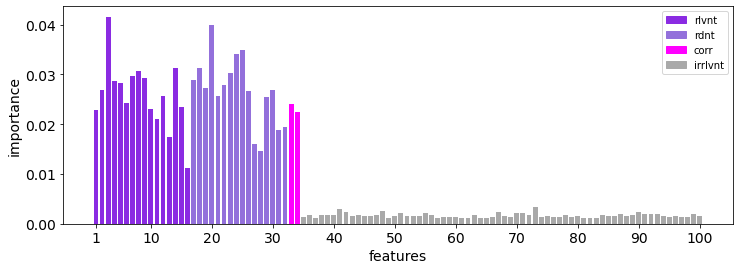

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


rfc = RandomForestClassifier(max_depth=2, random_state=0)
etc = ExtraTreesClassifier(n_estimators=100, random_state=0)


# make data
X, y = led(df, n_obs=400, n_I=66, seed=0)

rfc.fit(X, y)
etc.fit(X, y)

plt.figure(figsize=(12,4))
feature_score = (etc.feature_importances_+rfc.feature_importances_)/2
colors=16*['blueviolet']+16*['mediumpurple']+2*['magenta']+66*['darkgray']
plt.bar(range(1, X.shape[1]+1),feature_score, color=colors, label='RFC')

plt.legend()
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=14)
plt.ylabel('importance', size=14)
colors = {'rlvnt':'blueviolet', 'rdnt':'mediumpurple', 'corr':'magenta', 'irrlvnt':'darkgray'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig('imagesNew/led_scores.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# make data
X, y = led(df, n_obs=400, n_I=66, seed=0)

# Select top 20 based on combined scores
threshold = np.sort(rfc.feature_importances_ + etc.feature_importances_)[X.shape[1]-21]
idx = (rfc.feature_importances_ + etc.feature_importances_)>threshold
#idx[32:34]=[False, False]

#idx = np.array([12, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 30])
X = X[:,idx] # update X


# make containers for the results
scores_=list()
features_=list()
col_names = np.arange(1,101)[idx]
features_.append(col_names)
start= X.shape[1]
end=2

for j in range(start, end, -1):
    if j%4==0: print(j)
    accuracy, sprt = selector(X, y)
    scores_.append(accuracy)
    col_names = col_names[sprt]
    features_.append(col_names)
    X = X[:,sprt]

20
16
12
8
4


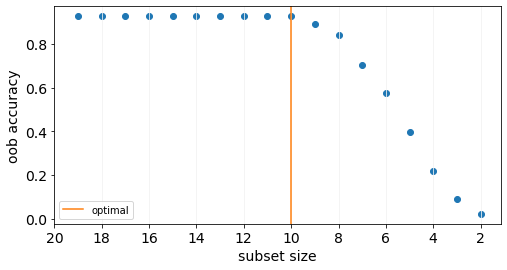

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(range(start-1, end-1, -1), scores_)
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

plt.gca().invert_xaxis()
plt.ylabel('oob accuracy', size=14)
plt.xlabel('subset size', size=14)
plt.axvline(10, color='C1', label='optimal')
plt.grid(axis='x', color='0.95')
plt.legend(loc='lower left')
plt.savefig('imagesNew/led_oob.pdf', bbox_inches='tight')
plt.show()

In [ ]:
top_ftrs = features_[-9]
print(top_ftrs)
idx_led = (top_ftrs-1)%16
print(list(df.columns[idx_led]))
print(scores_[cut_off])

[ 3 12 18 20 22 23 24 25 26 30]
['B', 'J', 'A2', 'C', 'D2', 'E', 'F', 'G1', 'G2', 'L']
0.9275


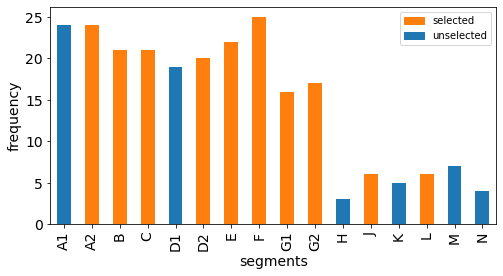

In [ ]:
import matplotlib.patches as mpatches

colors = np.array(16*['C0'])
colors[idx_led] = 'C1'

plt.figure(figsize=(8,4))
#plt.subplot(1,2,1)
df.sum().plot(kind='bar', color=colors)

sel_patch = mpatches.Patch(color='C1', label='selected')
unsel_patch = mpatches.Patch(color='C0', label='unselected')
plt.legend(handles=[sel_patch, unsel_patch])
plt.xlabel('segments', size=14)
plt.ylabel('frequency', size=14)
plt.savefig('imagesNew/led_freq.pdf', bbox_inches='tight')

#plt.subplot(1,2,2)

#%matplotlib inline
#import matplotlib.image as mpimg
#img = mpimg.imread('images/16-seg-annotated.png')
#imgplot = plt.imshow(img)
#plt.axis('off')
plt.show()


### MRMR

In [ ]:
# create some pandas data
X, y = led(df, n_obs=400, n_I=66, seed=0)
X = pd.DataFrame(X)
y = pd.Series(y)

# select top 10 features using mRMR
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X, y=y, K=16, return_scores=1)

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 12.86it/s]


In [ ]:
selected_features[0]

[0, 2, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

###Boruta

In [ ]:
# import the table showing which LED segments light up for each character

url = "https://raw.githubusercontent.com/SaidElnaffar/Synthetic-Datasets-for-Features-Selection-Algorithms/0ae683f12ae664291d195aff364dbeaa2b4014d9/16_segment_truth_table2.csv"
df = pd.read_csv(url, on_bad_lines='skip')

#df = pd.read_csv('16_segment_truth_table2.csv')
df = df.fillna(0)
df.index = df.iloc[:,0].values
df.drop(columns='char', inplace=True)
df = df.astype(int)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
np.random.seed(123)
random.seed(123)

rankings = []
for i in range(5):
    print(i)
    X, y = led(df, n_obs=400, n_I=66, seed=i)
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)
    feat_selector.fit(X, y)
    rankings.append(feat_selector.ranking_[:100])

np.median(rankings, axis=0).astype('int')

0
1
2
3
4


array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       26, 52, 36, 16, 43, 37, 12, 10, 49, 28, 40, 15, 40, 16, 31, 40, 37,
       29, 27, 45, 54, 56, 50, 22, 40, 34, 42, 26, 34, 31, 48, 28, 24, 60,
       23, 21, 30,  7,  9, 37,  4, 35, 18, 16, 25, 36, 60, 61, 59, 43, 45,
       38, 57, 17, 24, 19, 31, 27, 34, 31, 17, 53, 42, 31, 10, 36])

In [ ]:
med_rank = np.median(rankings, axis=0).astype('int')
np.where(med_rank==1)[0] +1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

### Genetic FS CV

In [ ]:
import random
import numpy as np
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from genetic_selection import GeneticSelectionCV

np.random.seed(123)
random.seed(123)


X, y = led(df, n_obs=400, n_I=66)
y=np.array(y)

estimator = LinearSVC()

selector = GeneticSelectionCV(
    estimator,
    cv=5,
    verbose=0,
    scoring="accuracy",
    max_features=10,
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=100,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.05,
    tournament_size=3,
    n_gen_no_change=10,
    caching=True,
    n_jobs=-1,
)
selector = selector.fit(X, y)
selector.support_.astype('int')

In [ ]:
np.where(selector.support_.astype('int')==1)[0] + 1

array([ 2,  3,  6,  7,  9, 15, 20, 24, 26, 83])

### RFE

In [ ]:
np.random.seed(123)
random.seed(123)

X, y = led(df, n_obs=400, n_I=66, seed=0)
estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X, y)
selector.ranking_

array([ 24,  20,  11,  14,   9,  17,  12,  19,  13,  18,  36,  16,  27,
        22,  25,  30,  15,   5,   3,   6,   1,  21,   4,   8,   2,   7,
        37,  26,  28,  10,  23,  29,  71,  31,  45,  99,  96,  79,  32,
        41,  49,  50,  75,  44,  43,  69,  35,  39,  57,  70,  52,  38,
        56,  68,  33,  42,  81,  88,  95,  77,  86,  85,  89,  62,  84,
        83,  59,  80,  65,  54,  64,  51,  47,  87,  74,  97,  90,  67,
        58,  98,  94, 100,  78,  66,  92,  91,  40,  63,  55,  48,  60,
        61,  72,  82,  53,  73,  76,  93,  46,  34])


### Lasso

In [ ]:
from sklearn.svm import LinearSVC
X, y = led(df, n_obs=400, n_I=66, seed=0)

np.random.seed(123)
random.seed(123)

#Lasso with C=0.1
rank_list=list()
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X, y)
print([i for i in range(100) if lsvc.coef_[0][i]!=0])

[8, 9, 18, 20, 22, 23, 32, 33, 34, 54]


In [ ]:
np.array([8, 9, 18, 20, 22, 23, 32, 33, 34, 54])+1

array([ 9, 10, 19, 21, 23, 24, 33, 34, 35, 55])

### ElesticNet

In [ ]:
from sklearn.linear_model import LogisticRegression
X, y = led(df, n_obs=400, n_I=66, seed=0)

np.random.seed(123)
random.seed(123)

lr = LogisticRegression(penalty = 'elasticnet',
                        solver = 'saga',
                        l1_ratio = 0.5,
                        C=0.2,
                        max_iter=10000)
lr.fit(X,y)
print([i for i in range(100) if lr.coef_[0][i]!=0])

[2, 4, 5, 6, 7, 8, 9, 22, 24, 25, 32, 33, 72]


In [ ]:
np.array([2, 4, 5, 6, 7, 8, 9, 22, 24, 25, 32, 33, 72])+1

array([ 3,  5,  6,  7,  8,  9, 10, 23, 25, 26, 33, 34, 73])

## KDD

### Preprocessing (run all cells)

In [ ]:
names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Non python/Papers/Feature selection dataset/FSA')

df=pd.read_csv("kddcup_data_10_percent_corrected_update", names=names)
print('Initial df shape:', df.shape)

# Remove redundant features
print(df['num_outbound_cmds'].value_counts())
df.drop('num_outbound_cmds', axis=1, inplace=True)
print(df['is_host_login'].value_counts())
df.drop('is_host_login', axis=1, inplace=True)

# Drop the duplicates
df.drop_duplicates(subset=None, keep='first', inplace=True)
print('Shape after drop:', df.shape)

Initial df shape: (494021, 42)
0    494021
Name: num_outbound_cmds, dtype: int64
0    494021
Name: is_host_login, dtype: int64
Shape after drop: (145586, 40)


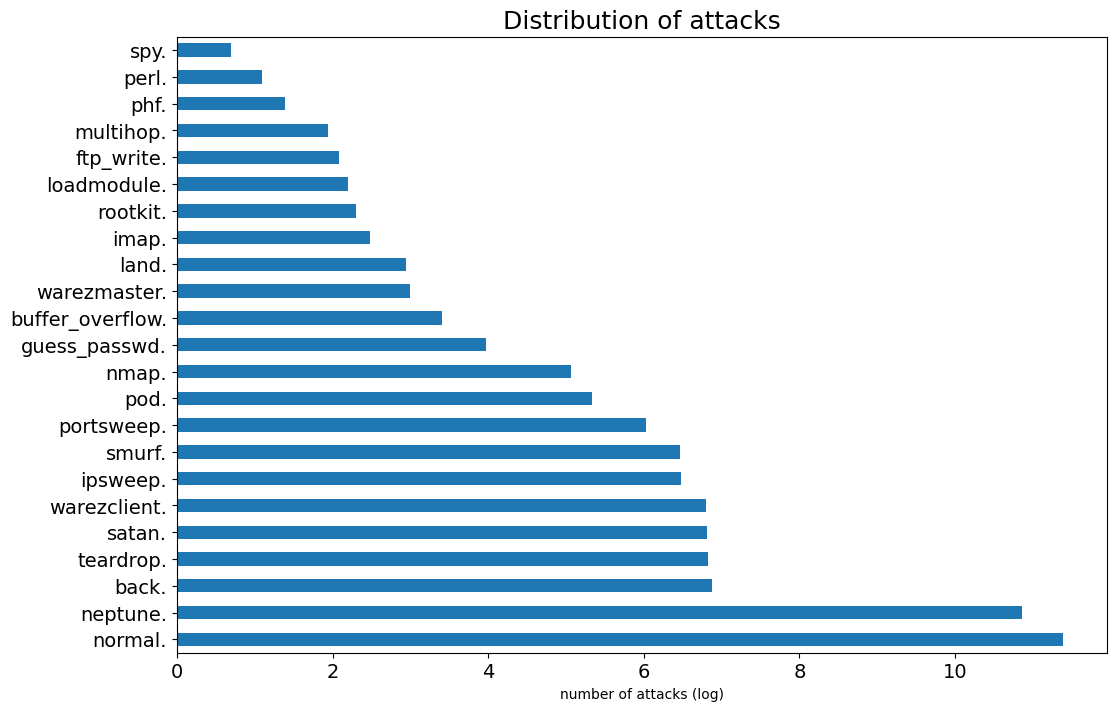

In [ ]:
import matplotlib

plt.figure(figsize=(12,8))
params = {'axes.titlesize':'18',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)
plt.title('Distribution of attacks')
df['label'].value_counts().apply(np.log).plot(kind='barh')
plt.xlabel('number of attacks (log)')
plt.show()

### Results

### NES

In [ ]:
# Define the categorical features
df2=df.copy()
cat_columns = ['protocol_type', 'service', 'flag', 'label']
df2[cat_columns] = df2[cat_columns].astype('category')


np.unique(df2.label, return_counts=True)

(array(['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
        'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
        'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
        'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.',
        'warezclient.', 'warezmaster.'], dtype=object),
 array([  968,    30,     8,    53,    12,   651,    19,     9,     7,
        51820,   158, 87832,     3,     4,   206,   416,    10,   906,
          641,     2,   918,   893,    20]))

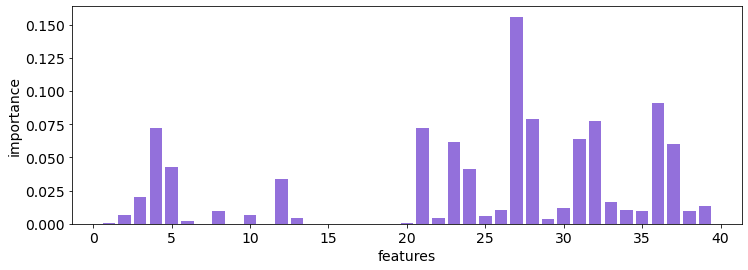

In [ ]:
# Evaluate features for ordinal-values data
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
df_ord = df2.copy()

# Turn the categorical to ordinal integers
df_ord[cat_columns] = df_ord[cat_columns].apply(lambda x: x.cat.codes)

X = df_ord.iloc[:,:-1]
y=df_ord.iloc[:,-1]


rfc = RandomForestClassifier(max_depth=2, random_state=0)
etc = ExtraTreesClassifier(n_estimators=100, random_state=0)

rfc.fit(X, y)
etc.fit(X, y)

plt.figure(figsize=(12,4))
feature_score = (etc.feature_importances_+rfc.feature_importances_)/2
#colors=16*['blueviolet']+16*['mediumpurple']+2*['magenta']+66*['darkgray']
plt.bar(range(1, X.shape[1]+1),feature_score, color='mediumpurple')
plt.bar(df.columns[:-1][idx],etc.feature_importances_[idx], label='etc')



#plt.legend()
#plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=14)
plt.ylabel('importance', size=14)
#colors = {'rlvnt':'blueviolet', 'rdnt':'mediumpurple', 'corr':'magenta', 'irrlvnt':'darkgray'}
#labels = list(colors.keys())
#handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#plt.legend(handles, labels)
plt.savefig('imagesNew/kdd_scores.pdf', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(df_ord.iloc[:,:-1], df_ord.iloc[:,-1],
                                                    test_size=0.3, random_state=1)

#m = int(1*X.shape[0])
#X = X.iloc[:m,:]
#y = y[:m]


# Select top 20 based on combined scores
threshold = np.sort(rfc.feature_importances_ + etc.feature_importances_)[X.shape[1]-21]
idx = (rfc.feature_importances_ + etc.feature_importances_)>threshold



# update X
col_names = np.array(X.columns)[idx]
X = X.values[:,idx]


# make containers for the results
scores_=list()
features_=list()
features_.append(col_names)
start= X.shape[1]
end=2

for j in range(start, end, -1):
    if j%4==0: print(j)
    accuracy, sprt = selector(X, y)
    scores_.append(accuracy)
    col_names = col_names[sprt]
    features_.append(col_names)
    X = X[:,sprt]

20
16
12
8
4


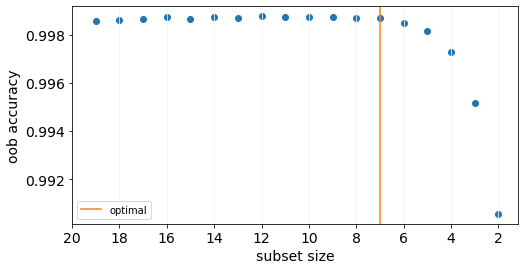

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(range(start-1, end-1, -1), scores_)
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

plt.gca().invert_xaxis()
plt.ylabel('oob accuracy', size=14)
plt.xlabel('subset size', size=14)
plt.axvline(7, color='C1', label='optimal')
plt.grid(axis='x', color='0.95')
plt.legend(loc='lower left')
plt.savefig('imagesNew/kdd_oob.pdf', bbox_inches='tight')
plt.show()

In [ ]:
X, X_test, y, y_test = train_test_split(df_ord.iloc[:,:-1], df_ord.iloc[:,-1],
                                                    test_size=0.3, random_state=1)

X = X.values
X_test = X_test.values

rfc2 = RandomForestClassifier()
rfc2.fit(X,y)
y_pred = rfc2.predict(X_test)
rfc2.score(X_test, y_test)

0.998900998259914

In [ ]:
X, X_test, y, y_test = train_test_split(df_ord.iloc[:,:-1], df_ord.iloc[:,-1],
                                                    test_size=0.3, random_state=1)

X = X.loc[:,features_[-6]].values
X_test = X_test.loc[:,features_[-6]].values

rfc2 = RandomForestClassifier()
rfc2.fit(X,y)
y_pred = rfc2.predict(X_test)
print(rfc2.score(X_test, y_test))

for i in range(len(features_[-6])):
    print(features_[-6][i])

0.9982828097811155
service
src_bytes
dst_host_count
dst_host_diff_srv_rate
dst_host_same_src_port_rate
dst_host_serror_rate
dst_host_rerror_rate


In [ ]:
X, X_test, y, y_test = train_test_split(df_ord.iloc[:,:-1], df_ord.iloc[:,-1],
                                                    test_size=0.3, random_state=1)

X = X.loc[:,features_[-5]].values
X_test = X_test.loc[:,features_[-5]].values

rfc2 = RandomForestClassifier()
rfc2.fit(X,y)
y_pred = rfc2.predict(X_test)
print(rfc2.score(X_test, y_test))

for i in range(len(features_[-5])):
    print(features_[-5][i])

0.998191226302775
service
src_bytes
dst_host_count
dst_host_diff_srv_rate
dst_host_same_src_port_rate
dst_host_serror_rate


In [ ]:
pd.crosstab(y_test,y_pred)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

### MRMR

In [ ]:
# create some pandas data
df_ord = df2.copy()
X, X_test, y, y_test = train_test_split(df_ord.iloc[:,:-1], df_ord.iloc[:,-1],
                                                    test_size=0.3, random_state=1)

#X, y = led(df, n_obs=400, n_I=66, seed=0)
#X = pd.DataFrame(X)
#y = pd.Series(y)

# select top 10 features using mRMR
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X, y=y, K=10, return_scores=1)

100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.84it/s]


In [ ]:
selected_features[0]

['wrong_fragment',
 'land',
 'num_failed_logins',
 'same_srv_rate',
 'urgent',
 'dst_bytes',
 'num_shells',
 'srv_count',
 'hot',
 'count']

In [ ]:
X, X_test, y, y_test = train_test_split(df_ord.iloc[:,:-1], df_ord.iloc[:,-1],
                                                    test_size=0.3, random_state=1)

X = X.loc[:,selected_features[0]].values
X_test = X_test.loc[:,selected_features[0]].values

rfc2 = RandomForestClassifier()
rfc2.fit(X,y)
y_pred = rfc2.predict(X_test)
print(rfc2.score(X_test, y_test))

0.9843621210733584
3
18
20
22
23
25


In [ ]:
X, X_test, y, y_test = train_test_split(df_ord.iloc[:,:-1], df_ord.iloc[:,-1],
                                                    test_size=0.3, random_state=1)

X = X.loc[:,selected_features[0][:6]].values
X_test = X_test.loc[:,selected_features[0][:6]].values

rfc2 = RandomForestClassifier()
rfc2.fit(X,y)
y_pred = rfc2.predict(X_test)
print(rfc2.score(X_test, y_test))

###Boruta

In [ ]:
from sklearn.model_selection import train_test_split
df_ord = df2.copy()

# Turn the categorical to ordinal integers
df_ord[cat_columns] = df_ord[cat_columns].apply(lambda x: x.cat.codes)
df_ord = df_ord.values

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
np.random.seed(123)
random.seed(123)

X, X_test, y, y_test = train_test_split(df_ord[:,:-1], df_ord[:,-1],
                                                    test_size=0.3, random_state=1)


rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)
feat_selector.fit(X, y)
feat_selector.ranking_


array([1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 8, 1, 1,
       2, 3, 2, 5, 2, 4, 7, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1])

In [ ]:
feat_selector.ranking_ = np.array([1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 8, 1, 1,
                                   2, 3, 2, 5, 2, 4, 7, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1])
np.where(med_rank==1)[0] +1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [ ]:
X, X_test, y, y_test = train_test_split(df_ord[:,:-1], df_ord[:,-1],
                                                    test_size=0.3, random_state=1)

X = X[:,feat_selector.ranking_==1]
X_test = X_test[:,feat_selector.ranking_==1]

rfc2 = RandomForestClassifier()
rfc2.fit(X,y)
y_pred = rfc2.predict(X_test)
print(rfc2.score(X_test, y_test))

0.9983514973898708


### Genetic FS

In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.ensemble import BaggingClassifier
from feature_selection_ga import FeatureSelectionGA, FitnessFunction
np.random.seed(123)
random.seed(123)


X, X_test, y, y_test = train_test_split(df_ord[:,:-1], df_ord[:,-1],
                                                    test_size=0.3, random_state=1)

#model = LinearSVC()
#model = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')

model = BaggingClassifier()
fsga = FeatureSelectionGA(model,X,y, ff_obj = FitnessFunction())
pop = fsga.generate(200)

In [ ]:
best_indiv =[1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]
best_indiv[:10]

[1, 1, 1, 1, 0, 0, 1, 1, 0, 0]

In [ ]:
X, X_test, y, y_test = train_test_split(df_ord[:,:-1], df_ord[:,-1],
                                                    test_size=0.3, random_state=1)

X = X[:,best_indiv==1]
X_test = X_test[:,best_indiv==1]

rfc2 = RandomForestClassifier()
rfc2.fit(X,y)
y_pred = rfc2.predict(X_test)
print(rfc2.score(X_test, y_test))

### Genetic FS CV

In [ ]:
import random
import numpy as np
from sklearn import linear_model
from sklearn.svm import LinearSVC
from genetic_selection import GeneticSelectionCV
from sklearn.model_selection import train_test_split

np.random.seed(123)
random.seed(123)


df_ord = df2.copy()
# Turn the categorical to ordinal integers
df_ord[cat_columns] = df_ord[cat_columns].apply(lambda x: x.cat.codes)
df_ord = df_ord.values

X, X_test, y, y_test = train_test_split(df_ord[:,:-1], df_ord[:,-1],
                                                    test_size=0.3, random_state=1)

estimator = LinearSVC()

selector = GeneticSelectionCV(
    estimator,
    cv=5,
    verbose=0,
    scoring="accuracy",
    max_features=10,
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=100,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.05,
    tournament_size=3,
    n_gen_no_change=10,
    caching=True,
    n_jobs=-1,
)
selector = selector.fit(X, y)
selector.support_.astype('int')

In [ ]:
X, X_test, y, y_test = train_test_split(df_ord[:,:-1], df_ord[:,-1],
                                                    test_size=0.3, random_state=1)

X = X[:,best_indiv==1]
X_test = X_test[:,best_indiv==1]

rfc2 = RandomForestClassifier()
rfc2.fit(X,y)
y_pred = rfc2.predict(X_test)
print(rfc2.score(X_test, y_test))

### RFE

In [ ]:
df2.shape

(145586, 40)

In [ ]:
df2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


###KDD Preprocessing II

In [ ]:
#After PreProcesing
df2 = df.copy()
#Take only numeric features
num_features = ["duration", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
                "num_access_files", "is_guest_login", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]
features = df2.loc[:,num_features].astype(float)

In [ ]:
#we are going to reduce the outputs to 'normal' and 'attack'
labels = df2.loc[:,'label'].copy()
labels[labels != 'normal.'] = 'attack.'
labels.value_counts()

normal.    87832
attack.    57754
Name: label, dtype: int64

In [ ]:
#Rescaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)


### Lasso

In [ ]:
#Training a classifier
from sklearn.svm import LinearSVC
np.random.seed(123)
random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.3, random_state=1)

lsvc = LinearSVC(C=0.05, max_iter=10000, penalty='l1', dual=False).fit(X_train, y_train)

selected_ = [i for i in range(X_train.shape[1]) if lsvc.coef_[0][i]!=0]
selected_

[2,
 4,
 6,
 8,
 10,
 16,
 17,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35]

In [ ]:
np.random.seed(123)
random.seed(123)

X_train = X_train[:,selected_]
X_test = X_test[:,selected_]

rfc2 = RandomForestClassifier()
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)
print(rfc2.score(X_test, y_test))

0.9985575602161371


### ElesticNet

In [ ]:
from sklearn.linear_model import LogisticRegression
np.random.seed(123)
random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.3, random_state=1)

lr = LogisticRegression(penalty = 'elasticnet',
                        solver = 'saga',
                        l1_ratio = 0.5,
                        C=0.05,
                        max_iter=10000)

lr.fit(X_train, y_train)

selected_ = [i for i in range(X_train.shape[1]) if lsvc.coef_[0][i]!=0]
selected_


[2,
 4,
 6,
 8,
 10,
 16,
 17,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35]

In [ ]:
np.random.seed(123)
random.seed(123)

X_train = X_train[:,selected_]
X_test = X_test[:,selected_]

rfc2 = RandomForestClassifier()
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)
print(rfc2.score(X_test, y_test))

0.9985575602161371


In [ ]:
recall={'ORAND':   [1.0 , 1.0 , 0.33 , 0.33 ,0.67 ,1.0,1.0],
'ANDOR': [1.0 , 1.0 , 1.0 ,0.5  ,1.0 ,1.0 , 1.0],
'ADDER': [ 1.0 , 1.0 , 1.0, 0.33    ,1.0,0.3,0.67 ],
'LED':  [0.71 ,1.0 ,1.0 , 0.43  ,0.64 ,0.36,0.43]}

In [ ]:
precision={'ORAND':   [ 1.0 , 0.3 ,0.25 , 0.25,0.20 ,0.38,0.30],
'ANDOR': [1.0 , 0.4 , 0.4 , 0.67  ,0.40 ,0.33,0.31],
'ADDER': [1.0 , 0.3 , 0.375, 0.2 ,0.30 ,0.14,0.28 ],
'LED':  [1.0 ,0.44 , 0.41 , 0.6,0.90 ,0.50,0.46]}

In [ ]:
import pandas as pd
df_recall = pd.DataFrame(recall)
df_precision = pd.DataFrame(precision)

In [ ]:
df_recall

,ORAND,ANDOR,ADDER,LED
0,1.00,1.0,1.00,0.71
1,1.00,1.0,1.00,1.00
2,0.33,1.0,1.00,1.00
3,0.33,0.5,0.33,0.43
4,0.67,1.0,1.00,0.64
5,1.00,1.0,0.30,0.36
6,1.00,1.0,0.67,0.43


In [ ]:
round(df_precision,2)

,ORAND,ANDOR,ADDER,LED
0,1.00,1.00,1.00,1.00
1,0.30,0.40,0.30,0.44
2,0.25,0.40,0.38,0.41
3,0.25,0.67,0.20,0.60
4,0.20,0.40,0.30,0.90
5,0.38,0.33,0.14,0.50
6,0.30,0.31,0.28,0.46
